In [2]:
import dask
from dask.distributed import Client, progress

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:54485 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GiB


In [3]:
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist


In [1]:
# import packages 
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping

## 1.  Nightlight Luminosity in Rwanda 

In the following session, I will: 
1. Download satellite nightlights image of the world from NOAA
2. Download the shapefile of Rwanda boundary
3. Do some exploratory analysis of the data

In [2]:
# download the night image folder
! pip install wget
import wget

night_image_url = 'https://ngdc.noaa.gov/eog/data/web_data/v4composites/F182010.v4.tar'
wget.download(night_image_url)

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=f7b5386fb91e792c6b3be49a04cf32a3183548dac28fa2534c0f925ad06cf2a1
  Stored in directory: /Users/elisaxchen/Library/Caches/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


'F182010.v4.tar'

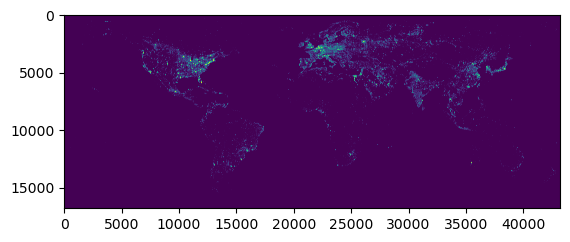

<AxesSubplot:>

In [4]:
# take a look at satellite nightlights image
fp = r'/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif'
night_img = rio.open(fp) 
show(night_img.read())

In [36]:
# check crs
night_img.crs

CRS.from_epsg(4326)

In [5]:
night_img.indexes # check the band

(1,)

In [6]:
# check the matrix shape 
# matrix shape (lines x columns)
night_img.shape

(16801, 43201)

In [11]:
# read in Rwanda shapefile file 
rwanda_shp = gpd.read_file('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project//raw_data/shapefiles/Sector_Boundary_2012.shp')

<AxesSubplot:>

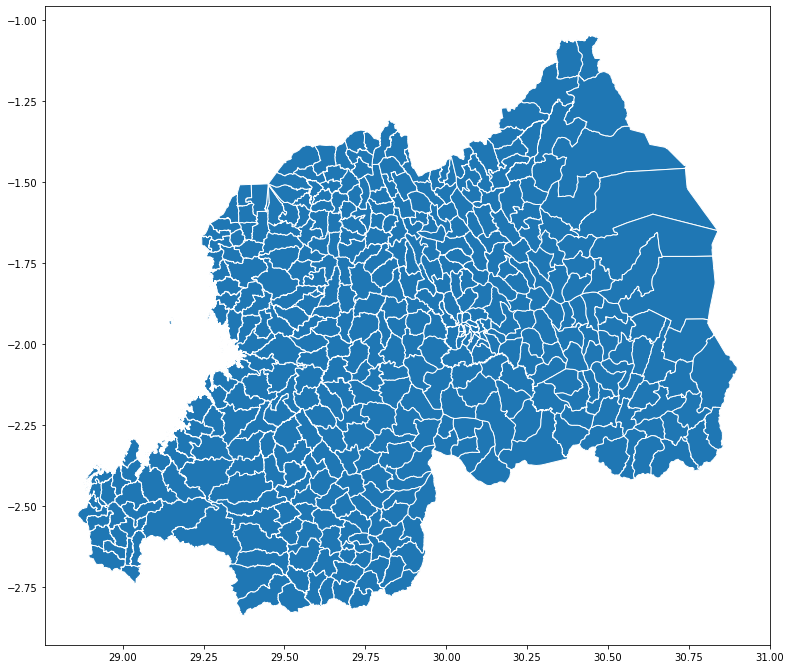

In [4]:
# plot the boundary of Rwanda 
%matplotlib inline
rwanda_shp.plot(figsize=(13,13), edgecolor="white")

In [31]:
rwanda_shp

,Prov_ID,Province,Dist_ID,District,Sect_ID,Sector,geometry
0,1.0,Kigali City,11.0,Nyarugenge,1101.0,Gitega,"POLYGON ((30.04829 -1.94176, 30.04833 -1.94178..."
1,1.0,Kigali City,11.0,Nyarugenge,1102.0,Kanyinya,"POLYGON ((29.98964 -1.86756, 29.98957 -1.86789..."
2,1.0,Kigali City,11.0,Nyarugenge,1103.0,Kigali,"POLYGON ((30.04030 -1.94181, 30.04036 -1.94183..."
3,1.0,Kigali City,11.0,Nyarugenge,1104.0,Kimisagara,"POLYGON ((30.04496 -1.93947, 30.04501 -1.93955..."
4,1.0,Kigali City,11.0,Nyarugenge,1105.0,Mageregere,"POLYGON ((30.05227 -2.00171, 30.05232 -2.00175..."
...,...,...,...,...,...,...,...
411,5.0,Eastern Province,57.0,Bugesera,5711.0,Nyarugenge,"POLYGON ((30.02756 -2.26839, 30.02810 -2.26985..."
412,5.0,Eastern Province,57.0,Bugesera,5712.0,Rilima,"POLYGON ((30.17277 -2.11490, 30.17365 -2.11542..."
413,5.0,Eastern Province,57.0,Bugesera,5713.0,Ruhuha,"POLYGON ((30.09253 -2.28683, 30.09287 -2.28766..."
414,5.0,Eastern Province,57.0,Bugesera,5714.0,Rweru,"POLYGON ((30.32350 -2.19875, 30.32362 -2.19909..."


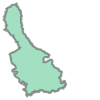

In [6]:
# Check the geometry for village/cluster 1 
rwanda_shp.geometry[1]


In [48]:
rwanda_shp.geometry[1].bounds

(29.977519331982606,
 -1.9520529192995302,
 30.03490574806802,
 -1.8667735496373912)

In [34]:
rwanda_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
# now clip the nightlight image with rwanda shapefile

# Read Shape file
with fiona.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project//raw_data/shapefiles/Sector_Boundary_2012.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# read imagery file
with rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif') as src:
    out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# Save clipped imagery
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/night_light_rwd.tif', "w", **out_meta) as dest:
    dest.write(out_image)

Here's what Rwanda looks like at night. It seems like it's hard to differciate poor/rich areas based on lightness, but if we extract features from this image, we might see a positive relationship between the light and wealth.

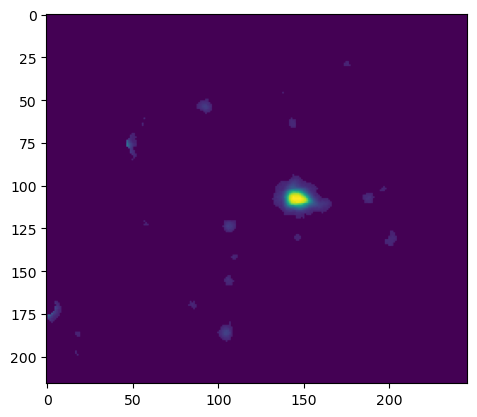

<AxesSubplot:>

In [10]:
# Open the clipped raster file 
# Plot a map of nightlight luminosity in Rwanda.
night_rwd = rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/night_light_rwd.tif')
show(night_rwd.read())

In [8]:
def get_shp_boundary(shp_file):
    """
    Function
    --------
    get_shp_extent

    Given a shapefile, get its boundary

    Parameters
    ----------
    shp_file : string
        Path to the shapefile
    
    Returns
    -------
    extent : tuple
        Boundary location of the shapefile (x_min, y_min, x_max, y_max)
    """
    import fiona
    shape = fiona.open(shp_file)
    extent = shape.bounds
    return extent

In [8]:
# get the country boundary 
import fiona
shape = fiona.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project//raw_data/shapefiles/Sector_Boundary_2012.shp')
extent = shape.bounds
extent

(28.861730820284293,
 -2.8402301026069785,
 30.89974664177404,
 -1.0471667072395556)

In [12]:
# find the tuple of max and min coordinates on each axis for each village 
rwanda_shp.geometry.bounds

,minx,miny,maxx,maxy
0,30.045711,-1.966104,30.060097,-1.940759
1,29.977519,-1.952053,30.034906,-1.866774
2,29.992899,-2.019377,30.041042,-1.941769
3,30.037965,-1.963317,30.055869,-1.939105
4,29.983285,-2.075769,30.086842,-2.001662
...,...,...,...,...
411,29.959209,-2.345492,30.038194,-2.261377
412,30.150738,-2.230545,30.262947,-2.111685
413,30.014584,-2.353686,30.103212,-2.283842
414,30.161406,-2.388536,30.374481,-2.197965


## 2. Process Rwandan DHS and Gather Cluster-level Wealth Data

In [13]:
import pandas as pd 
import numpy as np 

In [14]:
# import data 
dhs_rw = '/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/RWHR61FL/RWHR61FL.DAT'
village_loc = '/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/raw_data/rwanda_clusters_location.csv'

In [42]:
cluster_all = []
wealth_all = []
with open(dhs_rw) as f: 
    for line in f:
        cluster = int(line[15:23])
        wealth = int(line[230:238])/ 100000
        cluster_all.append(cluster)
        wealth_all.append(wealth)
        
df = pd.DataFrame({'cluster': cluster_all, 'wealth': wealth_all})

In [43]:
df.head()

,cluster,wealth
0,121,3.07037
1,121,1.48863
2,121,1.93735
3,121,0.14170
4,121,-0.07971


In [44]:
cluster_avg_wealth = df.groupby('cluster')['wealth'].mean().reset_index()
cluster_avg_wealth

,cluster,wealth
0,1,-0.386620
1,2,-0.421574
2,3,-0.449724
3,4,-0.390006
4,5,-0.416924
...,...,...
487,488,-0.490285
488,489,-0.387647
489,490,0.451675
490,491,-0.217502


In [45]:
cluster_loc = pd.read_csv(village_loc)

In [46]:
cluster_cor = cluster_loc[['DHSCLUST', 'LATNUM','LONGNUM']]
cluster_cor.head()

,DHSCLUST,LATNUM,LONGNUM
0,1.0,-2.532818,29.684726
1,2.0,-1.833858,30.310689
2,3.0,-1.888155,29.478298
3,4.0,-2.366763,30.521692
4,5.0,-2.171266,30.018541


In [47]:
# merge location data with asset data 
cluster_wealth_cor = cluster_avg_wealth.merge(cluster_cor, how = 'left', left_on = 'cluster', right_on = 'DHSCLUST')

In [48]:
cluster_wealth_cor

,cluster,wealth,DHSCLUST,LATNUM,LONGNUM
0,1,-0.386620,1.0,-2.532818,29.684726
1,2,-0.421574,2.0,-1.833858,30.310689
2,3,-0.449724,3.0,-1.888155,29.478298
3,4,-0.390006,4.0,-2.366763,30.521692
4,5,-0.416924,5.0,-2.171266,30.018541
...,...,...,...,...,...
487,488,-0.490285,488.0,-2.389778,29.451722
488,489,-0.387647,489.0,-2.144317,30.348895
489,490,0.451675,490.0,-1.967830,30.441541
490,491,-0.217502,491.0,-1.441294,30.063765


In [49]:
# save as csv file for future use 
cluster_wealth_cor.to_csv('cluster_wealth.csv')

## 3. Extract Nighttime Features from the Image 

In [21]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
import imageio
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib

In [22]:
from osgeo import gdal, ogr, osr

In [23]:
# Helper function to read a raster file
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

In [24]:
# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [25]:
# read the nightlight image
raster_file = '/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format; see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [27]:
# create a function
# take the average of the luminosity values for the nightlights locations surrounding the cluster centroid
def ext_night_light(img):
    idx, x, y = img
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # using 10* 10 pixels 
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx -5
    low_idx = lat_idx + 4 
    light_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1): 
            light = bands_data[j,i,0]
            light_100.append(light)
    light_100 = np.asarray(light_100)
    mean_ = np.mean(light_100)
    return pd.Series({'cluster_id': idx, 'nightlight_mean': mean_})

In [29]:
night_light_idx = cluster_wealth_cor.apply(lambda x: ext_night_light([x['cluster'],x['LONGNUM'], x['LATNUM']]), axis=1)

In [30]:
night_light_idx

,cluster_id,nightlight_mean
0,1.0,0.06
1,2.0,0.00
2,3.0,0.00
3,4.0,0.00
4,5.0,0.00
...,...,...
487,488.0,0.00
488,489.0,0.00
489,490.0,2.20
490,491.0,0.00


In [31]:
# merge it with the wealth data
night_light_wealth = night_light_idx.merge(cluster_wealth_cor, how = 'left', left_on = 'cluster_id', right_on = 'cluster')

In [32]:
night_light_wealth.head(10)

,cluster_id,nightlight_mean,cluster,wealth,DHSCLUST,LATNUM,LONGNUM
0,1.0,0.06,1,-0.386620,1.0,-2.532818,29.684726
1,2.0,0.00,2,-0.421574,2.0,-1.833858,30.310689
2,3.0,0.00,3,-0.449724,3.0,-1.888155,29.478298
3,4.0,0.00,4,-0.390006,4.0,-2.366763,30.521692
4,5.0,0.00,5,-0.416924,5.0,-2.171266,30.018541
5,6.0,6.08,6,-0.050272,6.0,-2.036917,30.114591
6,7.0,0.00,7,-0.396406,7.0,-1.768636,29.799135
7,8.0,0.00,8,-0.136730,8.0,-1.769425,29.967649
8,9.0,36.67,9,2.512280,9.0,-1.974834,30.111135
9,10.0,0.00,10,0.567510,10.0,-2.038221,30.310015


## 4. Modeling

Text(0, 0.5, 'Average Village Wealth')

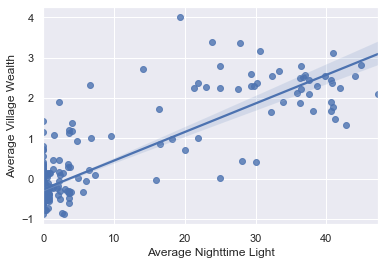

In [50]:
# plot the relationship between nighttime light and village wealth 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)
sns.regplot(x="nightlight_mean", y="wealth", data=night_light_wealth);
plt.xlabel('Average Nighttime Light')
plt.ylabel('Average Village Wealth')

In [51]:
import statsmodels.api as sm 

x = night_light_wealth['nightlight_mean']
y = night_light_wealth['wealth']
model = sm.OLS(y,x)
reg = model.fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                 wealth   R-squared (uncentered):                   0.654
Model:                            OLS   Adj. R-squared (uncentered):              0.654
Method:                 Least Squares   F-statistic:                              928.9
Date:                Tue, 31 May 2022   Prob (F-statistic):                   2.67e-115
Time:                        15:31:53   Log-Likelihood:                         -348.04
No. Observations:                 492   AIC:                                      698.1
Df Residuals:                     491   BIC:                                      702.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------